In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms # استعمال transforms من torch vision لتبيق عمليات preprocessing على الصور
import torch.nn.functional as F # import finctional that includes activation functions
from torch.autograd import Variable
import torchvision.utils as vutils# to save images
import torchvision
import torch.optim as optim#استعمال class optim


In [2]:

b_size = 64 # We set the size of the batch.
imageSize = 64 # We set the size of the generated images (64x64).
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
# Creating the transformations
transform = transforms.Compose([transforms.Resize((imageSize,imageSize)), transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)]) # We create a list of transformations (scaling, tensor conversion, normalization) to apply to the input images.

data_set=torchvision.datasets.MNIST(root='data',download=False,transform=transform)#if you dont have mnist data_Set then set download =True

Using device: cuda



In [3]:
dataloader = torch.utils.data.DataLoader(data_set, batch_size = b_size, shuffle = True, num_workers = 2) # We use dataLoader to get the images of the training set batch by batch.

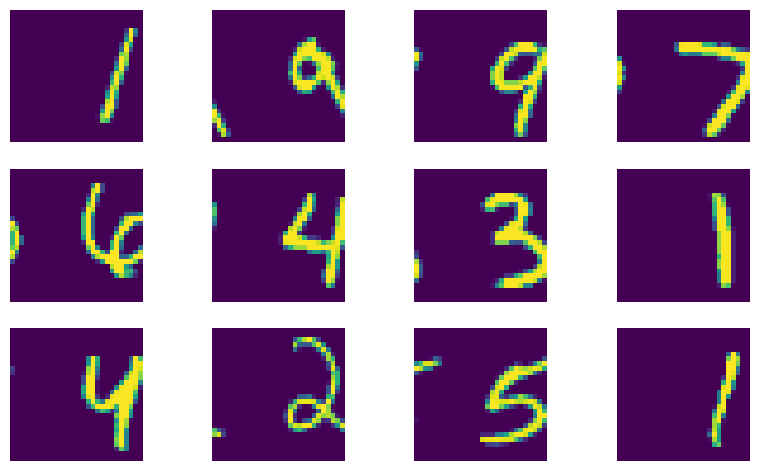

In [4]:
import gzip
import matplotlib.pyplot as plt
import numpy as np
f = gzip.open('data/MNIST/raw/t10k-images-idx3-ubyte.gz','r')
f.read(8)
fig = plt.figure(figsize=(10, 10))#create images matrix
image_size=28
num_images=5
for i in range(0,12):   
    buf = f.read(image_size * image_size * num_images)
    data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
    data = data.reshape(num_images, image_size, image_size, 1)
    image = np.asarray(data[2]).squeeze()
    fig.add_subplot(5, 4, i+1,)# add image to images matrix
    # showing image
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [4]:
for xb,yb in dataloader:
    print(yb)
    break

tensor([2, 3, 7, 1, 5, 8, 1, 6, 9, 8, 3, 2, 8, 8, 1, 7, 4, 5, 0, 2, 1, 4, 8, 8,
        6, 6, 8, 1, 7, 2, 0, 4, 3, 7, 2, 7, 2, 2, 6, 0, 4, 6, 0, 1, 3, 0, 0, 7,
        6, 8, 6, 9, 0, 8, 5, 7, 4, 1, 6, 8, 3, 9, 5, 1])


In [5]:
class Des(nn.Module):
    def __init__(self):
        super(Des,self).__init__()
        self.conv1=nn.Conv2d(2,64,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.conv2=nn.Conv2d(64,128,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch2=nn.BatchNorm2d(128)#input
        self.conv3=nn.Conv2d(128,256,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch3=nn.BatchNorm2d(256)
        self.conv4=nn.Conv2d(256,512,4,2,1,bias=False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.batch4=nn.BatchNorm2d(512)
        self.conv5=nn.Conv2d(512, 1, 4, 1, 0, bias = False)#input,n_feautre_maps,kernel_size,stride,padding,biase state
        self.embed=nn.Embedding(10,64*64)
    def disc(self,x):
        x=F.leaky_relu(self.conv1(x),negative_slope=0.2,inplace=True)# move the input through all the layers
        x=F.leaky_relu(self.batch2(self.conv2(x)),negative_slope=0.2,inplace=True)
        x=F.dropout2d(x,0.3)
        x=F.leaky_relu(self.batch3(self.conv3(x)),negative_slope=0.2,inplace=True)
        x=F.leaky_relu(self.batch4(self.conv4(x)),negative_slope=0.2,inplace=True)
        x=F.sigmoid(self.conv5(x))
        return x.view(-1)
    def forward(self,x,labels):
        embedding=self.embed(labels).view(labels.shape[0],1,64,64)
        #print(embedding.shape)
        #print(x.shape)
        x=torch.cat([x,embedding],dim=1)
        x=self.disc(x)
        return x
class Gen(nn.Module):
    def __init__(self):
        super(Gen,self).__init__()
        # the order of parameters are writen in the comments beside each line
        self.conv1=nn.ConvTranspose2d(200,512,4,1,0,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch1=nn.BatchNorm2d(512)
        self.conv2=nn.ConvTranspose2d(512,256,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch2=nn.BatchNorm2d(256)
        self.conv3=nn.ConvTranspose2d(256,128,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch3=nn.BatchNorm2d(128)
        self.conv4=nn.ConvTranspose2d(128,64,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch4=nn.BatchNorm2d(64)
        self.conv5=nn.ConvTranspose2d(64,1,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.embed=nn.Embedding(10,100)
    def gen(self,x):
        x=F.relu(self.batch1(self.conv1(x)),inplace=True)#means that it will modify the input directly, without allocating any additional output.
        #It can sometimes slightly decrease the memory usage
        x=F.relu(self.batch2(self.conv2(x)),inplace=True)
        x=F.dropout2d(x,0.25)
        x=F.relu(self.batch3(self.conv3(x)),inplace=True)
        x=F.relu(self.batch4(self.conv4(x)),inplace=True)
        x=F.tanh(self.conv5(x))
        return x
    def forward(self,x,labels):
        embedding=self.embed(labels).unsqueeze(2).unsqueeze(3)
        #print("gen")
        #print(embedding.shape)
        #print(x.shape)
        x=torch.cat([x,embedding],dim=1)
        x=self.gen(x)
        return x


In [7]:
g=Gen()
x=g.forward(torch.randn((3,100,1,1)),torch.tensor([2,3,9],dtype=torch.long))
print(x.shape)
#print(torch.tensor([2,3,9],dtype=torch.long).shape)

torch.Size([3, 1, 64, 64])


In [8]:
losses_g=[]#empty list to store genrator loss values so we can visualize them later
losses_d=[]#empty list to store descriminator loss values so we can visualize them later
def weights_init_normal(m):#weight initialization function for diffrent layes
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:# for convolution
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:#for batchnorm
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

gen=Gen().to(device)
desc=Des().to(device)
gen.apply(weights_init_normal)
desc.apply(weights_init_normal)


Des(
  (conv1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (embed): Embedding(10, 4096)
)

In [9]:
import os
def train(epochs,desc,gen,dataloader):
    optimizer_d=optim.Adam(desc.parameters(), lr = 0.0002, betas = (0.5, 0.999))# baetas are coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    optimizer_g=optim.Adam(gen.parameters(), lr = 0.0002, betas = (0.5, 0.999))# baetas are coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    loss_fn=nn.BCELoss()# set loss function to binary cross entropy
    try:
        os.mkdir('output')
        os.mkdir('models')
    except:
        pass
    for i in range(epochs):
        for j,data in enumerate(dataloader):
            # train desc on real
            optimizer_d.zero_grad()# set gradient to zero so that each iteration isnt affected with the ones before it
            real,labels=data# get real images data
            real=real.view(-1,1,64,64)# resize them to be (b_size,1,64,64)
            real=Variable(real).to(device)# set data device to GPU
            labels=Variable(labels).to(device)
            target=Variable(torch.ones(real.size()[0])).to(device)# creat a tensor of ones (real output)
            #print(real.shape)
            #print(labels.shape)
            output=desc.forward(real,labels)# get descriminator predictions on real data (supposed to be 1)
            #print('llll')
            err_d_real=loss_fn(output,target)# get loss on real data 
          
            #train desc on fake
            
            target=Variable(torch.zeros(real.size()[0])).to(device)# tensor of zeors
            noise=Variable(torch.randn((real.size()[0],100,1,1))).to(device)# create random noise tensor
            fake=gen.forward(noise,labels)# genrate fake image
            output=desc.forward(fake,labels)# get prediction of descriminator on fake images supposed to be 0
            err_d_fake=loss_fn(output,target)# get loss
            #gradient descent
            err_d=err_d_fake+err_d_real# add both losses of decriminator
            err_d.backward()# calculate the gradient descent
            optimizer_d.step()#update weights
            #train gen
            optimizer_g.zero_grad()# set genrator gradient to zero so it doesnt get affected by previous itterations
            target=Variable(torch.ones(real.size()[0])).to(device)#tensor of ones
            noise=Variable(torch.randn((real.size()[0],100,1,1))).to(device)# create random noise tensor
            fake=gen.forward(noise,labels)# genrate fake images
            output=desc.forward(fake,labels)# get prediction of descriminator on fake images supposed to be 1 
            err_g=loss_fn(output,target)# calculate loss
            err_g.backward()# calculate gradient descent
            optimizer_g.step()#update weight
            if j%10==0:
                print('-',end=' ')# print "-" each 10 itterations
        print('>\n')# print ">" at the end of each epoch
        print(f' err_d={err_d.data}  err_g={err_g.data}  {i}')
        losses_d.append(err_d.data)# append the loss value of descriminator so we can visualize it
        losses_g.append(err_g.data)# append the loss value of genrator so we can visualize it
        torch.save(gen,f'models//genrator_new_{i}.pt')# save models at a file named models
        torch.save(desc,f'models//discriminator_new_{i}.pt')
        vutils.save_image(real, f'real_1.jpg', normalize = True) # We save the real images of the minibatch.
        fake = gen.forward(noise,labels) # We get our fake generated images.
        vutils.save_image(fake.data, f'output//fake_1_{i}.jpg', normalize = True) # We also save the fake generated images of the minibatch.

In [10]:
train(20,desc,gen,dataloader)

C:\Users\abdel\anaconda3\envs\tfgpu\lib\site-packages\torch\nn\functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.8791414499282837  err_g=4.055726051330566  0
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=1.1568944454193115  err_g=6.630867004394531  1
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.22516502439975739  err_g=3.0995147228240967  2
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - >

 err_d=0.35229623317718506  err_g=3.9975218772888184  3
- - - - - - - - 

In [11]:
losses_desc=[]
for i in losses_d:
    losses_desc.append(float(i))# transform value to float
losses_gen=[]
for i in losses_g:
    losses_gen.append(float(i))


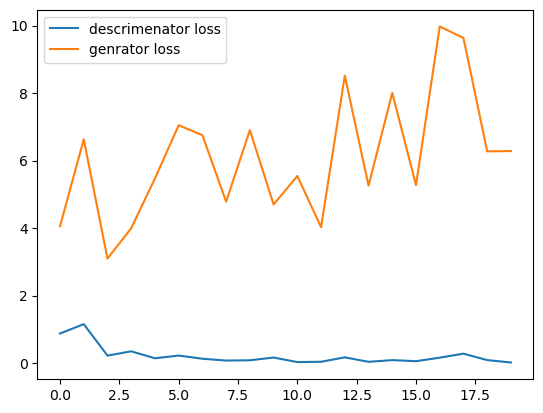

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses_desc,label='descrimenator loss')#visualize descriminator
plt.plot(losses_gen,label='genrator loss')#visualize genrator
plt.legend()
plt.show()

In [1]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Gen(nn.Module):
    def __init__(self):
        super(Gen,self).__init__()
        # the order of parameters are writen in the comments beside each line
        self.conv1=nn.ConvTranspose2d(200,512,4,1,0,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch1=nn.BatchNorm2d(512)
        self.conv2=nn.ConvTranspose2d(512,256,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch2=nn.BatchNorm2d(256)
        self.conv3=nn.ConvTranspose2d(256,128,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch3=nn.BatchNorm2d(128)
        self.conv4=nn.ConvTranspose2d(128,64,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.batch4=nn.BatchNorm2d(64)
        self.conv5=nn.ConvTranspose2d(64,1,4,2,1,bias=False)# input,number of output feautre maps,kernel size,stride,padding,biase=Flase
        self.embed=nn.Embedding(10,100)
    def gen(self,x):
        x=F.relu(self.batch1(self.conv1(x)),inplace=True)#means that it will modify the input directly, without allocating any additional output.
        #It can sometimes slightly decrease the memory usage
        x=F.relu(self.batch2(self.conv2(x)),inplace=True)
        x=F.dropout2d(x,0.25)
        x=F.relu(self.batch3(self.conv3(x)),inplace=True)
        x=F.relu(self.batch4(self.conv4(x)),inplace=True)
        x=F.tanh(self.conv5(x))
        return x
    def forward(self,x,labels):
        embedding=self.embed(labels).unsqueeze(2).unsqueeze(3)
        #print("gen")
        #print(embedding.shape)
        #print(x.shape)
        x=torch.cat([x,embedding],dim=1)
        x=self.gen(x)
        return x
gen=torch.load('models//genrator_new_19.pt')
def genrate(l,filename="output.jpg"):
    noise=torch.randn((1,100,1,1)).to(device)
    fake=gen(noise,torch.tensor([l],dtype=torch.long).to(device))
    vutils.save_image(fake.data, filename, normalize = True) # We also save the fake generated images of the minibatch.
    img=plt.imread(filename)
    plt.imshow(img)
    plt.show()

what digit do you want to genrate:  9


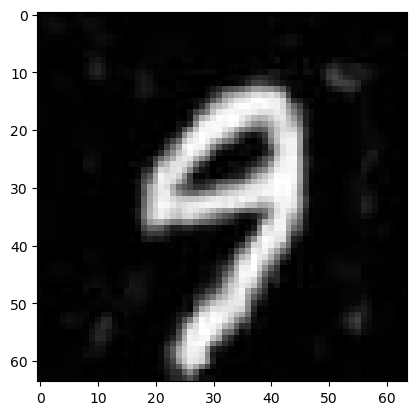

In [12]:
l=int(input("what digit do you want to genrate: "))
genrate(l)